# Collaborative filtering based on interactions dataset 

In [62]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import time
import gzip
import matplotlib.pyplot as plt

In [116]:
# Set pandas to display all columns
pd.reset_option('display.max_columns')
pd.reset_option("display.max_seq_items")
pd.reset_option("display.max_colwidth")

In [66]:
# Import user interactions
interaction_chunks = pd.read_csv("../raw_data/goodreads_interactions.csv", chunksize=50_000)

## Define functions to downcast data and get score

In [65]:
# Downcasting columns
def downcast(df):
    int_8_cols = ["is_read", "rating", "is_reviewed"]
    df[int_8_cols] = df[int_8_cols].astype("int8")
    df[["user_id", "book_id"]] = df[["user_id", "book_id"]].astype("int32")
    return df

# get score
def get_score(interactions_df): #TODO: think of how to include rating in score
    return interactions_df["is_read"] \
           + interactions_df["rating"] \
           + interactions_df["is_reviewed"] * 2

## Test functions on one chunk

In [67]:
# See the first chunk to get a sense of data
first_chunk = next(interaction_chunks)
print("Samples")
display(first_chunk.sample(3))

print("Info")
display(first_chunk.info())

# Processing interactions data
first_chunk.dtypes
print("Do int32 values retain full info? Let's check:", "\n")
for col in first_chunk.columns:
    test = (first_chunk[col].astype("int32") == first_chunk[col]).all()
    print(f"{col}: {'yes' if test else 'no'}")

print("\nWhat about int8?\n")
for col in first_chunk.columns:
    test = (first_chunk[col].astype("int8") == first_chunk[col]).all()
    print(f"{col}: {'yes' if test else 'no'}")

print("\nMemory usage after downcasting")
downcast(first_chunk)
display(first_chunk.info())

Samples


,user_id,book_id,is_read,rating,is_reviewed
36142,84,24328,1,5,0
42485,101,27901,1,5,0
26437,50,17631,1,4,1


Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      50000 non-null  int64
 1   book_id      50000 non-null  int64
 2   is_read      50000 non-null  int64
 3   rating       50000 non-null  int64
 4   is_reviewed  50000 non-null  int64
dtypes: int64(5)
memory usage: 1.9 MB


None

Do int32 values retain full info? Let's check: 

user_id: yes
book_id: yes
is_read: yes
rating: yes
is_reviewed: yes

What about int8?

user_id: yes
book_id: no
is_read: yes
rating: yes
is_reviewed: yes

Memory usage after downcasting
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      50000 non-null  int32
 1   book_id      50000 non-null  int32
 2   is_read      50000 non-null  int8 
 3   rating       50000 non-null  int8 
 4   is_reviewed  50000 non-null  int8 
dtypes: int32(2), int8(3)
memory usage: 537.2 KB


None

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

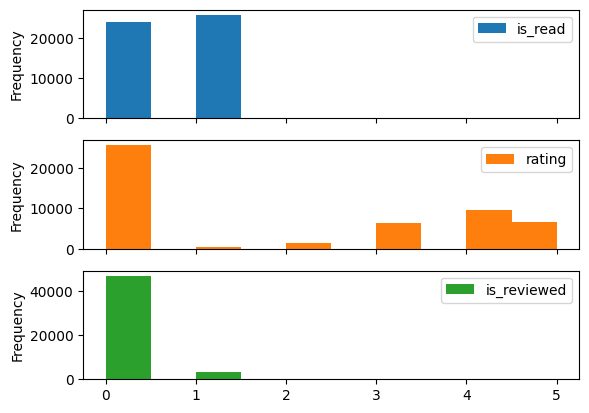

In [175]:
# See distribution for is_read, rating, and i_reviewed
first_chunk.sample(5)
first_chunk[["is_read", "rating", "is_reviewed"]].plot(kind="hist", subplots=True, xticks=[0, 1, 2, 3, 4, 5])


In [180]:
# get score
first_chunk["score"] = get_score(first_chunk)
first_chunk.sample(3)

,user_id,book_id,is_read,rating,is_reviewed,score
151300,342,79699,1,5,1,8
180899,403,91702,0,0,0,0
198873,437,99366,0,0,0,0


## Process in chunks to get CSR matrix of scores for 1_400_000 user-item pairs

In [68]:

# Build stable ID maps... chatgpt recommended
user_ids = set()
book_ids = set()

start = time.time()
for chunk in pd.read_csv("../raw_data/goodreads_interactions.csv", chunksize=200_000):
    chunk = downcast(chunk)

    user_ids.update(chunk["user_id"].unique().tolist())
    book_ids.update(chunk["book_id"].unique().tolist())

# Stable 0-based mappings...
user_ids = list(user_ids)
book_ids = list(book_ids)

user_map = {u: i for i, u in enumerate(user_ids)}
book_map = {b: i for i, b in enumerate(book_ids)}

print(f"No. of users: {len(user_map)}", f"No. of books: {len(book_map)}", sep="\n")
end = time.time()
duration = end - start
print(f"Time taken: {duration}")


No. of users: 876145
No. of books: 2360650
Time taken: 42.708595991134644


In [69]:
# Getting arrays for users, items, and scores
from IPython.display import clear_output
user_list = []
book_list = []
score_list = []

start = time.time()
for chunk_no, chunk in enumerate(pd.read_csv("../raw_data/goodreads_interactions.csv", chunksize=200_000)):
    clear_output(wait=True)
    print(f"Processed {chunk_no} chunks")
    chunk = downcast(chunk)
    scores = get_score(chunk)

    # Map to 0-based index
    u_idx = chunk["user_id"].map(user_map)
    b_idx = chunk["book_id"].map(book_map)

    # drop NaN
    mask = u_idx.notna() & b_idx.notna()
    u_idx = u_idx[mask]
    b_idx = b_idx[mask]
    scores = scores[mask]

    user_list.append(u_idx.to_numpy())
    book_list.append(b_idx.to_numpy())
    score_list.append(scores.to_numpy())
    # Last chunk to be processes is currently: 5
    if chunk_no > 5:
        break
end = time.time()
# Make 1D arrays:
user_idx = np.concatenate(user_list)
book_idx = np.concatenate(book_list)
scores   = np.concatenate(score_list)

duration = end - start
print(f"Time taken: {duration}")

Processed 6 chunks
Time taken: 9.515913009643555


In [70]:
# Create sparse matrix of scores. Rows are users and columns are books
from scipy.sparse import csr_matrix

matrix = csr_matrix(
    (scores, (user_idx, book_idx)),
    dtype="float32"
)

In [6]:
# not all user-book pairs exist in the chunk. Check chunk by loc
# Index is between 1200000 and 1400000

i_loc = 1400000 - 2008
user = chunk.loc[i_loc, ["user_id"]].values
book = chunk.loc[i_loc, ["book_id"]].values
print(f"User no {user} for book no {book}")
display(chunk.loc[i_loc])

print(f"Score for user {user} for book no {book} is:")
display(get_score(chunk.loc[i_loc]))

print("Checking whether matrix score corresponds to this...")
matrix[user, book]


User no [2772] for book no [14848]


user_id         2772
book_id        14848
is_read            1
rating             2
is_reviewed        0
Name: 1397992, dtype: int32

Score for user [2772] for book no [14848] is:


np.int32(3)

Checking whether matrix score corresponds to this...


matrix([[3.]], dtype=float32)

# Test a first model using Implicit library

In [71]:
from implicit.als import AlternatingLeastSquares

In [72]:
user_items_full = matrix.tocsr()
n_users, n_items = user_items_full.shape

# build train as a copy
user_items_train = user_items_full.copy().tocsr()

# for each user, hold out 1 interacted item (if they have any)
test_items = {}  # user_id -> set of held-out item_ids

for u in range(n_users):
    start, end = user_items_full.indptr[u], user_items_full.indptr[u+1]
    items = user_items_full.indices[start:end]

    if len(items) == 0:
        continue

    held_out = np.random.choice(items, size=1, replace=False)
    test_items[u] = set(held_out)

    # remove held-out interactions from the train matrix
    for i in held_out:
        user_items_train[u, i] = 0

user_items_train.eliminate_zeros()

In [73]:
# Instantiate model
model = AlternatingLeastSquares(
    factors = 128,
    regularization=0.1,
    iterations=30
)
model.fit(user_items_train)

100%|██████████| 30/30 [01:11<00:00,  2.39s/it]


In [ ]:
# Debugging error below
# print("mat shape:", matrix.shape[0])                     # should be (num_users, num_items)
# print("user_factors shape:", model.user_factors.shape)  # (num_users, n_factors)
print(f"Shape of model.user_factors : {model.user_factors.shape[0]}")
print(f"Shape of model.item_factors: {model.item_factors.shape[0]}")

Shape of user_item matrix: (1942, 374976)
Shape of item_user matrix: (374976, 1942)
Shape of model.user_factors : 1942
Shape of model.item_factors: 374976


In [ ]:
# Get some recommendations
user = 100
top_3_recs = model.recommend(userid=user, user_items=matrix[user], N=10)[0][:3]
top_3_recs

array([ 1526, 19408,  6401], dtype=int32)

In [ ]:
# Match to top recs

# Suppress setting with copy warning
pd.options.mode.chained_assignment = None  # default='warn'
recommended_books = dict({int(i): None for i in top_3_recs})
remaining = set(int(i) for i in top_3_recs)
book_chunks = pd.read_json("../raw_data/goodreads_books.json.gz",
                           lines=True,
                           compression="gzip",
                           chunksize=50_000)
for chunk_no, chunk in enumerate(book_chunks):
    clear_output(wait=True)
    print(f"checking chunk no. {chunk_no}")

    # Keep only 2 columns and downcast them
    chunk = chunk[["book_id", "title"]]
    chunk["book_id"] = chunk["book_id"].astype("int32")

    # Check if matches exist
    matches = chunk[chunk["book_id"].isin(remaining)]
    if matches.empty:       # If no id found, move to next chunk
        continue
    # Append if match is found
    print(f"Found a match in chunk no. {chunk_no}")
    for book_id, title in zip(matches["book_id"], matches["title"]):
        if recommended_books[book_id] is None:
            recommended_books[book_id] = title
            remaining.discard(book_id)

    # Stop once all titles found
    if not remaining:
        break


checking chunk no. 47


In [ ]:
recommended_books

({1526: 'The Oresteia: Agamemnon/The Libation Bearers/The Eumenides',
  19408: None,
  6401: 'Prophecy: What the Future Holds For You'},
 {19408})

In [37]:
# Check user and the books they've rated
interactions = pd.read_csv("../raw_data/goodreads_interactions.csv",
                           nrows=100000)

In [39]:
interactions[(interactions["user_id"] == user) &
             (interactions["is_read"] == 1)]

,user_id,book_id,is_read,rating,is_reviewed
42159,100,536,1,4,0
42160,100,443,1,5,0
42161,100,1221,1,3,0
42162,100,459,1,2,0
42163,100,1201,1,4,0
...,...,...,...,...,...
42325,100,27795,1,5,0
42326,100,27794,1,5,1
42327,100,27793,1,5,1
42328,100,27792,1,5,1


## Creating test set to test recommendations using chatGPT

In [48]:

user_items_full = user_items.tocsr()
n_users, n_items = user_items_full.shape

# build train as a copy
user_items_train = user_items_full.copy().tocsr()

# for each user, hold out 1 interacted item (if they have any)
test_items = {}  # user_id -> set of held-out item_ids

for u in range(n_users):
    start, end = user_items_full.indptr[u], user_items_full.indptr[u+1]
    items = user_items_full.indices[start:end]

    if len(items) == 0:
        continue

    held_out = np.random.choice(items, size=1, replace=False)
    test_items[u] = set(held_out)

    # remove held-out interactions from the train matrix
    for i in held_out:
        user_items_train[u, i] = 0

user_items_train.eliminate_zeros()


In [61]:
K = 10
hits = 0
total = 0

for u, positives in test_items.items():
    if not positives:
        continue

    # get recommendations for this user from the TRAIN matrix
    rec_ids, _ = model.recommend(
        u,
        user_items_train[u],
        N=K
    )

    rec_set = set(rec_ids)
    # count how many test positives appear in top-K
    hits += len(positives & rec_set)
    total += len(positives)

recall_at_k = hits / total if total > 0 else 0.0
print("Recall@{} = {:.4f}".format(K, recall_at_k))


Recall@10 = 0.1061


# Books dataset exploration
All columns are object type, so number ones need to be converted. <br>
We may select languages that are eng or '' (as those are Eng too, it seems) <br>
We may want to make individual columns for popular shelves (such as 'to-read count') <br>

In [212]:
books_50k = pd.read_json("../raw_data/goodreads_books.json.gz",
                         lines=True,
                         compression="gzip",
                         nrows=50_000)

In [213]:
books_50k.columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')

In [274]:
pd.reset_option('display.max_columns')
pd.reset_option("display.max_seq_items")
pd.reset_option("display.max_colwidth")

cols_to_keep = [
    "text_reviews_count",
    "language_code",
    "popular_shelves",
    "average_rating",
    "description",
    "authors",
    "num_pages",
    "publication_year",
    "ratings_count",
    "book_id",
    "work_id"
]
books_50k = books_50k[cols_to_keep]
books_50k.sample(2)

,text_reviews_count,language_code,popular_shelves,average_rating,description,authors,num_pages,publication_year,ratings_count,book_id,work_id
17860,3,,"[{'count': '2', 'name': 'read-2017'}, {'count'...",4.42,"Fur alle Leser, die sich jemals eine magische ...","[{'author_id': '16823618', 'role': ''}]",,,3,35553656,56371733
15722,251,spa,"[{'count': '213303', 'name': 'to-read'}, {'cou...",3.78,Una nave espacial que es un mundo diminuto.\nG...,"[{'author_id': '4018722', 'role': ''}]",528,2012,932,13146226,13082532


In [290]:
# Genres
print("Genres Dataset Columns")
print(genres.columns, "\n")

print("Size of dataset", genres.shape[0])
print("Dataset dtypes", "\n", genres.dtypes)

# Null values
# Map empty dicts to null
genres["genres"] = genres["genres"].map(
    lambda s: s if len(s) > 0 else pd.NA
)
print("\n", "Null values in genres")
print(genres.isnull().sum())
genres.sample(3)


Genres Dataset Columns
Index(['book_id', 'genres'], dtype='object') 

Size of dataset 2360655
Dataset dtypes 
 book_id     int64
genres     object
dtype: object

 Null values in genres
book_id         0
genres     409513
dtype: int64


,book_id,genres
1364200,30815001,"{'fantasy, paranormal': 6, 'fiction': 2, 'roma..."
1691488,26983,"{'children': 3, 'young-adult': 1, 'history, hi..."
1354295,25600261,{'romance': 2}


In [309]:
# Get top 3 genres for every book
def get_top_genres(genre_dict):
    if isinstance(genre_dict, dict):
        print((max(genre_dict, key = genre_dict.get)))
get_top_genres({'fantasy': 10, 'fiction': 12})

fiction


In [110]:
print("Books Dataset")
print(books_50k.dtypes)


text_reviews_count    object
language_code         object
popular_shelves       object
average_rating        object
description           object
authors               object
num_pages             object
publication_year      object
ratings_count         object
book_id                int64
work_id               object
dtype: object

In [116]:
# change dtypes
num_cols = ['text_reviews_count',
            'average_rating',
            'num_pages',
            'ratings_count']

# num_pages has several blank values. First check if any values other than digits
books_50k.loc[:, num_cols] = books_50k[num_cols].replace(r"^\s*$", pd.NA, regex=True)

books_50k.isna().sum()

text_reviews_count        9
language_code             0
popular_shelves           0
average_rating            9
description               0
authors                   0
num_pages             16178
publication_year          0
ratings_count             9
book_id                   0
work_id                   0
dtype: int64

In [120]:
# Convert dtypes
for col in num_cols:
    books_50k.loc[:, col] = pd.to_numeric(books_50k[col], errors='coerce')

books_50k.dtypes

text_reviews_count    float64
language_code          object
popular_shelves        object
average_rating        float64
description            object
authors                object
num_pages             float64
publication_year       object
ratings_count         float64
book_id                 int64
work_id                object
dtype: object

In [121]:
books_50k[num_cols].describe()

,text_reviews_count,average_rating,num_pages,ratings_count
count,49991.000000,49991.000000,33822.000000,49991.00000
mean,30.922126,3.867237,290.168529,427.61341
std,350.734013,0.535778,5140.716885,6697.53684
min,0.000000,0.000000,0.000000,0.00000
25%,2.000000,3.630000,148.000000,6.00000
50%,4.000000,3.910000,246.000000,21.00000
75%,12.000000,4.160000,345.000000,81.00000
max,38878.000000,5.000000,945077.000000,575163.00000


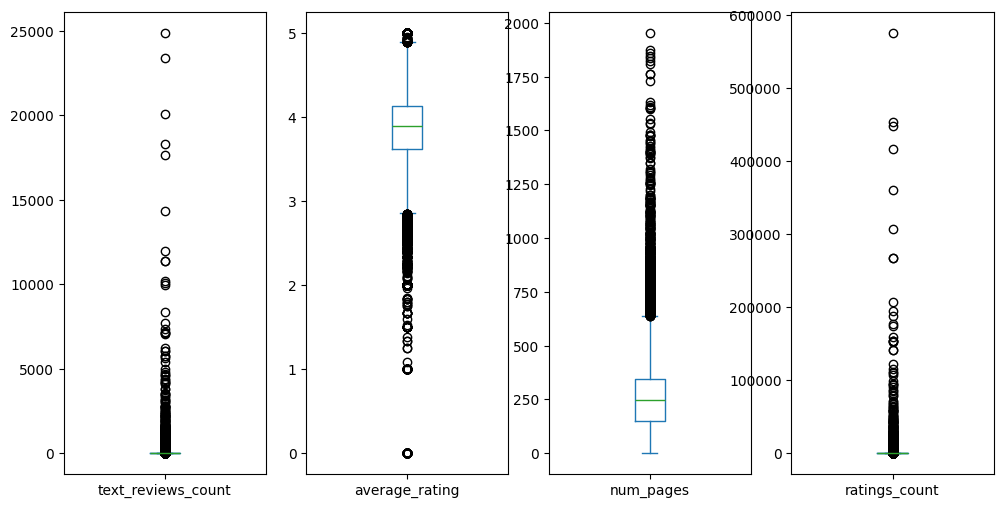

In [123]:
# books_50k[num_cols].plot(subplots=True, kind='hist', figsize=(8, 10))
books_50k[num_cols].plot(kind='box', subplots=True, figsize=(12, 6))
# Removing max from text_reviews_count and keeping num_pages below 2000
books_50k = books_50k[
    (books_50k['text_reviews_count'] < 38878.000000) &
    (books_50k['num_pages'] < 2000)
]

(array([3.3697e+04, 5.1000e+01, 1.6000e+01, 8.0000e+00, 4.0000e+00,
        5.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([     0.  ,  28758.15,  57516.3 ,  86274.45, 115032.6 , 143790.75,
        172548.9 , 201307.05, 230065.2 , 258823.35, 287581.5 , 316339.65,
        345097.8 , 373855.95, 402614.1 , 431372.25, 460130.4 , 488888.55,
        517646.7 , 546404.85, 575163.  ]),
 <BarContainer object of 20 artists>)

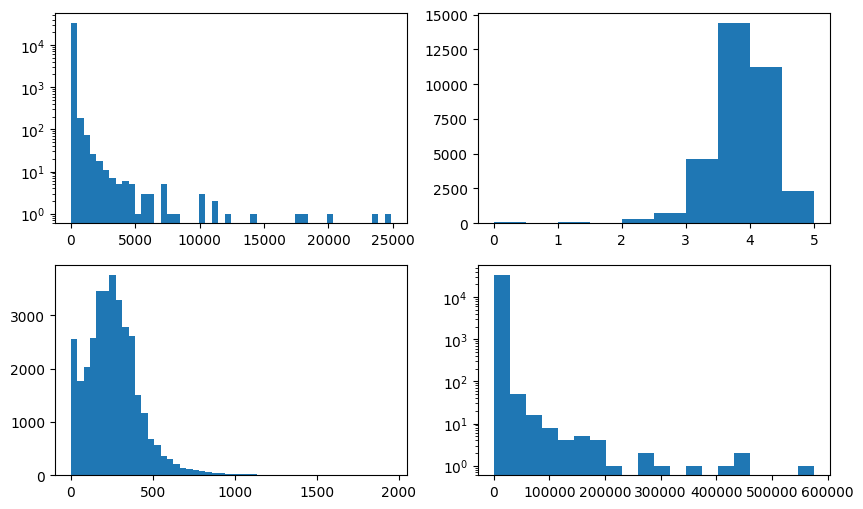

In [124]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
ax1.hist(books_50k['text_reviews_count'], bins=50, log=True)
ax2.hist(books_50k['average_rating'])
ax3.hist(books_50k['num_pages'], bins=50)
ax4.hist(books_50k['ratings_count'], bins=20, log=True)

In [ ]:
def extract_authors(li):
    authors = []
    for author_dict in li:
        authors.append(
            author_dict['author_id']
        )

    return authors

books_50k["extractd_authors"] = books_50k["authors"].apply(
    extract_authors
)

In [257]:
def extract_popular_shelves(li):
    popularity_threshold = 500
    shelves = []
    for d in li:
        if int(d["count"]) > popularity_threshold:
            shelves.append({d["name"]: d["count"]})
    return shelves

popular_shelves = books_50k["popular_shelves"].apply(extract_popular_shelves)

0                                                                               []
1                                                            [{'to-read': '2634'}]
2                                                                               []
3        [{'to-read': '7615'}, {'chick-lit': '728'}, {'currently-reading': '673'}]
4                                                                               []
                                           ...                                    
49995                                                                           []
49996                                                                           []
49997                                                                           []
49998      [{'to-read': '2977'}, {'fiction': '765'}, {'currently-reading': '513'}]
49999           [{'to-read': '2990'}, {'fantasy': '1195'}, {'young-adult': '639'}]
Name: popular_shelves, Length: 50000, dtype: object

In [259]:
from collections import Counter
all_shelves = Counter()

for book_shelves in popular_shelves:
    for shelf in book_shelves:
        shelf_name = list(shelf.keys())[0]
        all_shelves.update([shelf_name])

all_shelves

Counter({'to-read': 13157,
         'currently-reading': 2391,
         'fiction': 1782,
         'favorites': 1729,
         'fantasy': 998,
         'classics': 859,
         'owned': 775,
         'books-i-own': 765,
         'young-adult': 693,
         'classic': 505,
         'romance': 490,
         'historical-fiction': 435,
         'ya': 404,
         'mystery': 385,
         'literature': 333,
         'favourites': 327,
         'science-fiction': 315,
         'series': 289,
         'sci-fi': 271,
         'non-fiction': 271,
         'book-club': 232,
         'owned-books': 228,
         'novels': 213,
         'paranormal': 203,
         'kindle': 193,
         'horror': 185,
         'adventure': 185,
         'childrens': 184,
         'contemporary': 173,
         'historical': 158,
         'children': 152,
         'urban-fantasy': 144,
         'nonfiction': 137,
         'philosophy': 135,
         'children-s': 127,
         'school': 124,
         'dystopian':

In [ ]:
# Examining categorical columns
cat_cols = ['country_code', 'language_code']
pd.DataFrame(books_50k[cat_cols].value_counts())


count
country_code language_code       
US                          12941
             eng            10635
             en-US           1430
             spa              935
             en-GB            840
...                           ...
             fao                1
             gla                1
             ota                1
             glg                1
             dum                1

[86 rows x 1 columns]

In [22]:
# check language column
# Show count for all languages
pd.set_option('display.max_rows', None)
display(books_50k['language_code'].value_counts().sort_values())
pd.reset_option('display.max_rows')

# keep only eng lang books
eng_lang = ['eng', 'en-US', 'en-GB', 'en-CA', '']
books_50k = books_50k[books_50k['language_code'].isin(eng_lang)]


language_code
dum          1
pra          1
lat          1
ota          1
arw          1
enm          1
aze          1
fao          1
crh          1
gla          1
glg          1
mus          2
tgl          2
sqi          2
grc          2
pt-BR        2
es-MX        2
kan          2
mya          2
wel          2
mkd          3
hye          3
guj          3
--           3
en           3
nno          3
kur          4
tel          4
nep          5
bos          5
mon          5
mar          6
isl          6
mul          6
fil          7
kor          8
nob          8
mal          8
afr          8
tam         13
slv         14
urd         15
kat         16
pes         18
cat         19
hin         19
heb         20
ukr         23
slo         38
lav         41
lit         41
est         42
zho         42
hun         43
srp         54
tha         54
nor         60
scr         63
ben         66
vie         74
rum        100
dan        110
msa        127
pol        133
rus        135
bul        

In [23]:
# Check similar books column
books_50k.similar_books.apply(lambda x: len(x)).sort_values()

# check num pages column
books_50k.num_pages.value_counts().sort_index()
display(books_50k['num_pages'].quantile([0.25, 0.5, 0.75, 0.9, 0.99, 1]))

# remove the massive book as outlier
books_50k

0.25       144.0
0.50       245.0
0.75       336.0
0.90       435.0
0.99       812.0
1.00    945077.0
Name: num_pages, dtype: float64

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,0312853122,1.0,[],US,,"[{'count': '3', 'name': 'to-read'}, {'count': ...",,false,4.00,,[],,Paperback,https://www.goodreads.com/book/show/5333265-w-...,"[{'author_id': '604031', 'role': ''}]",St. Martin's Press,256.0,1,9780312853129,9,,1984,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5333265,3.0,5400751,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film
1,0743509986,6.0,[],US,,"[{'count': '2634', 'name': 'to-read'}, {'count...",,false,3.23,B000FC0PBC,"[8709549, 17074050, 28937, 158816, 228563, 112...","Anita Diamant's international bestseller ""The ...",Audio CD,https://www.goodreads.com/book/show/1333909.Go...,"[{'author_id': '626222', 'role': ''}]",Simon & Schuster Audio,NaN,1,9780743509985,10,Abridged,2001,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1333909,10.0,1323437,Good Harbor,Good Harbor
2,,7.0,[189911],US,eng,"[{'count': '58', 'name': 'to-read'}, {'count':...",B00071IKUY,false,4.03,,"[19997, 828466, 1569323, 425389, 1176674, 2627...",Omnibus book club edition containing the Ladie...,Hardcover,https://www.goodreads.com/book/show/7327624-th...,"[{'author_id': '10333', 'role': ''}]","Nelson Doubleday, Inc.",600.0,,,,Book Club Edition,1987,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,7327624,140.0,8948723,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ..."
3,0743294297,3282.0,[],US,eng,"[{'count': '7615', 'name': 'to-read'}, {'count...",,false,3.49,B002ENBLOK,"[6604176, 6054190, 2285777, 82641, 7569453, 70...",Addie Downs and Valerie Adler were eight when ...,Hardcover,https://www.goodreads.com/book/show/6066819-be...,"[{'author_id': '9212', 'role': ''}]",Atria Books,368.0,14,9780743294294,7,,2009,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6066819,51184.0,6243154,Best Friends Forever,Best Friends Forever
4,0850308712,5.0,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,3.40,,[],,,https://www.goodreads.com/book/show/287140.Run...,"[{'author_id': '149918', 'role': ''}]",,NaN,,9780850308716,,,,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,287140,15.0,278577,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49992,1542910188,1.0,[],US,,[],,false,5.00,B06X6GFWXJ,[],Complex Three...in the heart of the Republic's...,Paperback,https://www.goodreads.com/book/show/34300575-c...,"[{'author_id': '6942150', 'role': ''}]",Createspace Independent Publishing Platform,NaN,6,9781542910187,2,,2017,https://www.goodreads.com/book/show/34300575-c...,https://images.gr-assets.com/books/1487166076m...,34300575,1.0,55354290,Complex Three,Complex Three
49994,,2.0,[],US,,"[{'count': '25', 'name': 'to-read'}, {'count':...",B00XS47ASA,true,4.53,B0175P4BRK,[],The craft of home cheesemaking is exploding in...,,https://www.goodreads.com/book/show/25561514-m...,"[{'author_id': '3455913', 'role': ''}]",,NaN,,,,,,https://www.goodreads.com/book/show/25561514-m...,https://s.gr-assets.com/assets/nophoto/book/11...,25561514,8.0,45358569,Mastering Basic Cheesemaking: The Fun and Fund...,Mastering Basic Cheesemaking: The Fun and Fund...
49997,148472741X,3.0,[],US,,"[{'count': '17', 'name': 'to-read'}, {'count':...",,false,4.31,B009OIZ9M8,[],Join in the festivities of the season as Mike ...,Hardcover,https://www.goodreads.com/

In [24]:

# describe
books_50k[num_cols].describe()


,text_reviews_count,average_rating,num_pages,ratings_count
count,40956.000000,40956.000000,25919.000000,40956.000000
mean,35.701265,3.887848,292.650025,492.058282
std,386.415484,0.522771,5871.581166,7050.420417
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.650000,144.000000,6.000000
50%,4.000000,3.920000,245.000000,23.000000
75%,14.000000,4.170000,336.000000,93.000000
max,38878.000000,5.000000,945077.000000,575163.000000


In [25]:
# check max values for num cols
books_50k[books_50k['num_pages'] == 945077.000000]

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
18037,,30.0,[],US,eng,"[{'count': '46530', 'name': 'currently-reading...",B003ODIZL6,true,3.97,,"[6183819, 12728698, 8294444, 874941, 130068, 2...","""Oxford's American editors drew on its 200-mil...",Kindle Edition,https://www.goodreads.com/book/show/18684543-t...,"[{'author_id': '14392', 'role': 'Editor'}]",Oxford University Press Inc.,945077.0,,,,2nd Edition,2008,https://www.goodreads.com/book/show/18684543-t...,https://images.gr-assets.com/books/1382015770m...,18684543,378.0,762000,The New Oxford American Dictionary,The New Oxford American Dictionary


<Axes: ylabel='Frequency'>

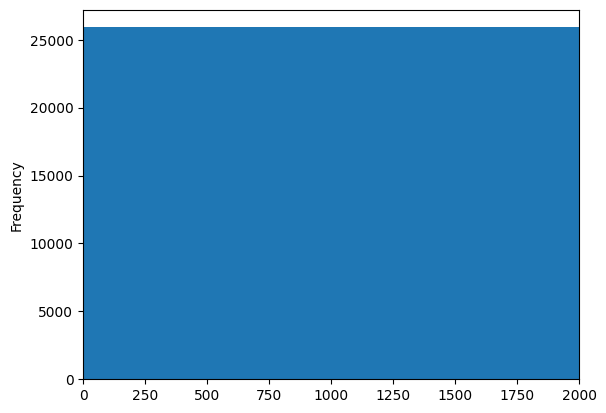

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize=(10,6))
# ax[0, 0].hist(books_50k['num_pages'], bins=20)
# ax[0, 0].set_xlim(0, 2000)
num_cols
books_50k.num_pages.plot(kind='hist', xlim=(0, 2000))

In [27]:
books_50k['num_pages'].quantile([0.5, 0.9, 0.99, 0.999])

0.500     245.00
0.900     435.00
0.990     812.00
0.999    1878.56
Name: num_pages, dtype: float64

In [28]:
books_50k.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40964 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isbn                  40964 non-null  object 
 1   text_reviews_count    40956 non-null  float64
 2   series                40964 non-null  object 
 3   country_code          40956 non-null  object 
 4   language_code         40964 non-null  object 
 5   popular_shelves       40964 non-null  object 
 6   asin                  40964 non-null  object 
 7   is_ebook              40964 non-null  object 
 8   average_rating        40956 non-null  float64
 9   kindle_asin           40964 non-null  object 
 10  similar_books         40964 non-null  object 
 11  description           40964 non-null  object 
 12  format                40964 non-null  object 
 13  link                  40964 non-null  object 
 14  authors               40964 non-null  object 
 15  publisher             40

In [30]:
books_50k.country_code.unique()

array(['US', <NA>], dtype=object)

In [ ]:
# for dummy model, keep only some columns
books_50k.columns.tolist()
books_50k_small = books_50k[['isbn',
                             'text_reviews_count',
                             'average_rating',
                             'publication_year',
                             'ratings_count']]  # No num pages as it has many missing.

books_50k_small.dropna(how='all', inplace=True)

/var/folders/6s/v193bdc16850v6kfnm2_q0tw0000gn/T/ipykernel_84576/757337865.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_50k_small.dropna(how='all', inplace=True)


In [52]:
books_50k_small

,isbn,text_reviews_count,average_rating,publication_year,ratings_count
0,0312853122,1.0,4.00,1984,3.0
1,0743509986,6.0,3.23,2001,10.0
2,,7.0,4.03,1987,140.0
3,0743294297,3282.0,3.49,2009,51184.0
4,0850308712,5.0,3.40,,15.0
...,...,...,...,...,...
49992,1542910188,1.0,5.00,2017,1.0
49994,,2.0,4.53,,8.0
49997,148472741X,3.0,4.31,2016,13.0
49998,0099740516,36.0,3.95,1997,190.0
